In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import pandas as pd

#Constants
#Cornea layer lengths, no need to change
L_endo = 0.005e-1 #endothelium thickness (cm)
L_stroma = L_endo + 0.45e-1 #stroma (cm)
L_epi = L_stroma + 0.05e-1 #epithelium thickness (cm)

#Oxygen tension of aqueous humor in anterior chamber
Pac = 24 #(mmHg) (P at x = 0)

#Oxygen permeability in cornea --> Dk in (cm^2 mL O2 / s mL mmHg)
Dk_stroma = 8.62e-10
Dk_epi = Dk_stroma/1.59
Dk_endo = Dk_stroma/5.66

#Maximum oxygen consumption rates
Q_stroma = 5.75e-5
Q_lens = 0
Q_epi = Q_stroma / 0.11
Q_endo = Q_stroma / 0.02

#Constant used for Michaelis-Menten equation
Km = 2.2 #mmHg

In [ ]:
#Functions

#O2: solve for P distribution given contact lens thickness, lens permeability, and P of the atmosphere
def O2(thickness, Dk_lens, Pair):
  nodes = 800
  L_lens = L_epi + thickness
  x = np.linspace(0, L_lens, nodes)
  dx = x[1] - x[0]
  Dk_array = np.empty_like(x)
  Dk_array[x <= L_endo] = Dk_endo
  Dk_array[(x > L_endo) & (x <= L_stroma)] = Dk_stroma
  Dk_array[(x > L_stroma) & (x <= L_epi)] = Dk_epi
  Dk_array[x > L_epi] = Dk_lens
  def Qp(p, x):
      Q = np.zeros_like(p, dtype=float)
      ppos = np.maximum(p, 0.0)
      mask_endo   = (x <= L_endo)
      mask_stroma = (x > L_endo) & (x <= L_stroma)
      mask_epi    = (x > L_stroma) & (x <= L_epi)
      mask_lens   = (x > L_epi)
      if np.any(mask_endo):
          Q[mask_endo] = Q_endo * (ppos[mask_endo] / (Km + ppos[mask_endo]))
      if np.any(mask_stroma):
          Q[mask_stroma] = Q_stroma * (ppos[mask_stroma] / (Km + ppos[mask_stroma]))
      if np.any(mask_epi):
          Q[mask_epi] = Q_epi * (ppos[mask_epi] / (Km + ppos[mask_epi]))
      if np.any(mask_lens):
          Q[mask_lens] = Q_lens * (ppos[mask_lens] / (Km + ppos[mask_lens]))
      return Q

  #Finite-difference method
  def residual(p_inner):
      p = np.empty(nodes, dtype=float)
      p[0] = Pac
      p[-1] = Pair
      p[1:-1] = p_inner
      # Find D, k between nodes
      Dk_btw = 0.5 * (Dk_array[:-1] + Dk_array[1:])
      flux = Dk_btw * (p[1:] - p[:-1]) / dx
      div = (flux[1:] - flux[:-1]) / dx
      Qnodes = Qp(p[1:-1], x[1:-1]) #Reaction term
      return div - Qnodes #beacause steady-state

  #Initial linear guess
  p0 = np.linspace(Pac, Pair, nodes)[1:-1]

  #Solve equation
  sol = root(residual, p0, method='hybr', tol=1e-9)

  #Reconstructs full P including BCs
  P = np.empty(nodes)
  P[0] = Pac
  P[-1] = Pair
  P[1:-1] = sol.x
  return x, P

#stats: solves for the average P and edge P of each solution returned by O2, requires distance array and P array, both from O2 function
def stats(x, P):
  #Find P at each interface
  endo_idx = np.abs(x - L_endo).argmin()
  endo_val = P[endo_idx]
  stroma_idx = np.abs(x - L_stroma).argmin()
  stroma_val = P[stroma_idx]
  epi_idx = np.abs(x - L_epi).argmin()
  epi_val = P[epi_idx]

  print(f"Endothelium edge: {endo_val} mmHg")
  print(f"Stroma edge: {stroma_val} mmHg")
  print(f"Epithelium edge: {epi_val} mmHg")

  #Finds average P in each layer
  endo_avg = np.average(P[0:endo_idx])
  stroma_avg = np.average(P[endo_idx:stroma_idx])
  epi_avg = np.average(P[stroma_idx:epi_idx])
  lens_avg = np.average(P[epi_idx:-1])
  cornea_avg = np.average(P[0:epi_idx])

  print(f"Endothelium average: {endo_avg} mmHg")
  print(f"Endothelium average: {endo_avg} mmHg")
  print(f"Epithelium average: {epi_avg} mmHg")
  print(f"Lens average: {lens_avg} mmHg")
  print(f"Cornea average: {cornea_avg} mmHg")
  return

Endothelium edge: 23.679231116286505 mmHg
Stroma edge: 115.36562461185403 mmHg
Epithelium edge: 155.0 mmHg
Endothelium average: 23.565193075090168 mmHg
Endothelium average: 23.565193075090168 mmHg
Epithelium average: 132.9618455038948 mmHg
Lens average: nan mmHg
Cornea average: 65.64953858823029 mmHg
Endothelium edge: 18.713039472715643 mmHg
Stroma edge: 5.036018507679915 mmHg
Epithelium edge: 18.720092640337473 mmHg
Endothelium average: 21.217135125911636 mmHg
Endothelium average: 21.217135125911636 mmHg
Epithelium average: 10.03067894342774 mmHg
Lens average: 86.15757257089213 mmHg
Cornea average: 5.99104581534508 mmHg
Endothelium edge: 18.32658959695875 mmHg
Stroma edge: 15.845823546046054 mmHg
Epithelium edge: 35.720308411953845 mmHg
Endothelium average: 21.311758803659995 mmHg
Endothelium average: 21.311758803659995 mmHg
Epithelium average: 23.747813593254037 mmHg
Lens average: 95.0154152129479 mmHg
Cornea average: 10.263578642184038 mmHg
Endothelium edge: 18.10792283747225 mmHg
S

/tmp/ipython-input-4036438365.py:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axvspan(L_epi*1e4, np.max([x[-1], x1[-1], x2[-1]])*1e4, color='gray', alpha=0.2, edgecolor = 'none')


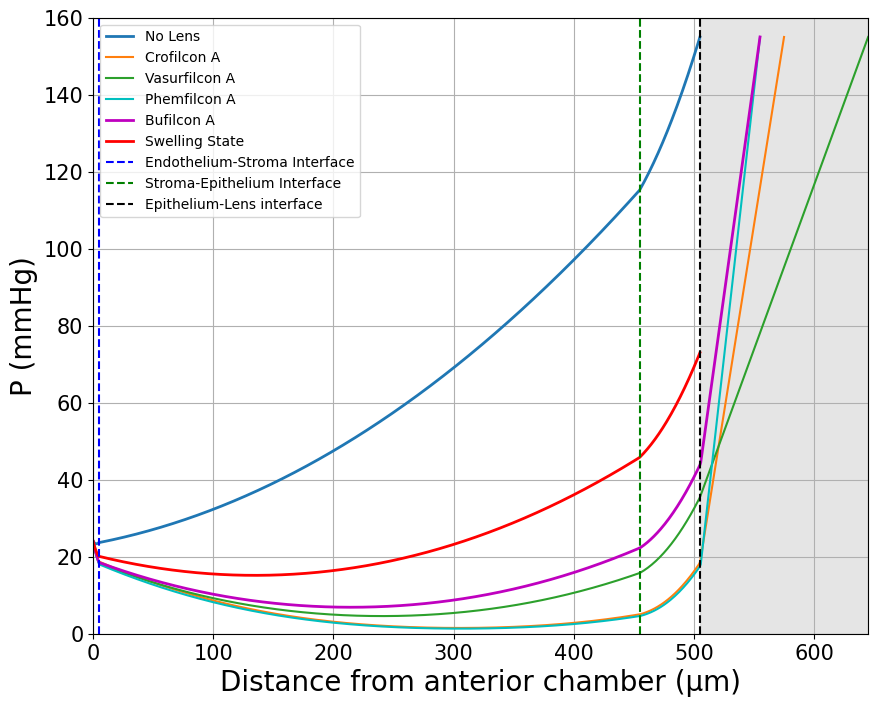

In [ ]:
#Calls functions and plots results
x, P = O2(0, 0, 155)
stats(x, P)
x1, P1 = O2(0.007, 13e-11, 155)
stats(x1, P1)
x2, P2 = O2(0.014, 39e-11, 155)
stats(x2, P2)
x3, P3 = O2(0.005, 9e-11, 155)
stats(x3, P3)
x4, P4 = O2(0.005, 16e-11, 155)
stats(x4, P4)
x5, P5 = O2(0, 0, 73)
stats(x5, P5)
plt.figure(figsize=(10,8))
plt.plot(x*1e4, P, linewidth=2, label = 'No Lens')
plt.plot(x1*1e4, P1, label = 'Crofilcon A')
plt.plot(x2*1e4, P2, label = 'Vasurfilcon A')
plt.plot(x3*1e4, P3, color = 'c', label = 'Phemfilcon A')
plt.plot(x4*1e4, P4, color = 'm', linewidth=2, label = 'Bufilcon A')
plt.plot(x5*1e4, P5, color = 'r', linewidth=2, label = 'Swelling State')
plt.axvline(L_endo*1e4, color='b', ls='--', label='Endothelium-Stroma Interface')
plt.axvline(L_stroma*1e4, color='g', ls='--', label='Stroma-Epithelium Interface')
plt.axvline(L_epi*1e4, color='k', ls='--', label='Epithelium-Lens interface')
plt.axvspan(L_epi*1e4, np.max([x[-1], x1[-1], x2[-1]])*1e4, color='gray', alpha=0.2, edgecolor = 'none')
plt.xlabel('Distance from anterior chamber (µm)', fontsize = '20')
plt.xlim(0, np.max([x[-1], x1[-1], x2[-1]])*1e4)
plt.ylim(0,160)
plt.yticks(fontsize = '15')
plt.xticks(fontsize = '15')
plt.ylabel('P (mmHg)', fontsize = '20')
plt.grid(True)
plt.legend()
plt.savefig("Senofilcon.png")
plt.show()

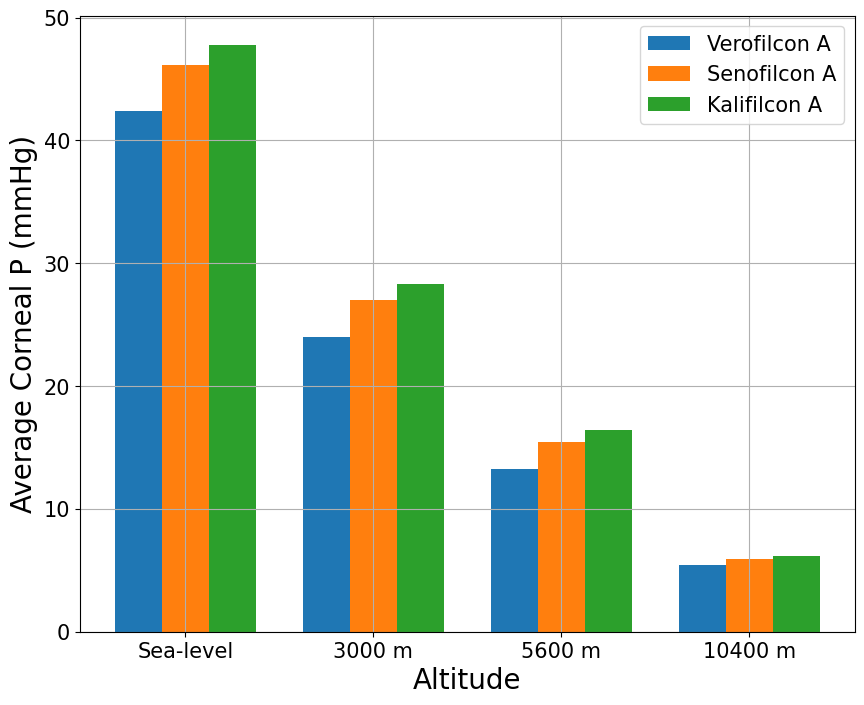

In [ ]:
#Sensitivity analysis bar graph
P_V = [42.42, 23.97, 13.24, 5.43]
P_S = [46.14, 26.98, 15.41,5.91]
P_K = [47.76, 28.29, 16.40, 6.17]
altitude = ['Sea-level', '3000 m', '5600 m', '10400 m']
x = np.arange(4)
width = 0.25
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid(True)
ax.bar(x - width, P_V, width, color='tab:blue', label = 'Verofilcon A')
ax.bar(x, P_S, width, color='tab:orange', label = 'Senofilcon A' )
ax.bar(x + width, P_K, width, color='tab:green', label = 'Kalifilcon A')
ax.set_ylabel('Average Corneal P (mmHg)', fontsize = 20)
ax.set_xlabel('Altitude', fontsize = 20)
ax.set_xticks(x)
ax.set_xticklabels(altitude, fontsize = 15)
ax.legend(fontsize = 15)
ax.tick_params(axis='y', labelsize=15)